# Model for SIPs

In which we implement the MOL model described on p. 8 of my workbook.

In [1]:
#Packages we are using
using DifferentialEquations
using Plots

#Function to model the absorption of gas into SIP material in linear coordinates via MOL approach.
#Discussed on p. 8 of workbook.
#Inputs: f - function for rate of change in reactive species concentration. 
#L - length of domain, m
#tf - end time of simulation, s. 
#p - partial pressure of gas above SIP (this must be a function of time.), Pa.
#c0 and w0 - initial CO2 and reactant concentration
#k2 - second order rate constant, m3/mol.s
#Ss and Sl - solubility of gas in solid and liquid phases, respectively, mol/m3.Pa
#Ds and Dl - diffusivity of gas in solid and liquid phases, respectively, m2/s
#ɛ - The solid fraction inside the particle.
#m - The number of mesh points.
function LinearSIP(f,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m)
    
    #Pertinent Mesh Values
    h = L/m         #Distance between neighbouring grid points
    
    #Generic Ddash and kdash parameters
    Ddash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Sl/Ss)
    kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Sl/Ss)
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[i] = Ddash/h^2*(2c[2]-2c[1]) - kdash*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Ddash/h^2*(c[i-1]-2c[i]+c[i+1]) - kdash*c[i]*w[i]
            elseif i == m
                dudt[i] = Ddash/h^2*(c[m-1]-2c[m] + Ss*p(t)) - kdash*c[m]*w[m] 
            elseif m+1 <= i <= 2m
                dudt[i] = f(c[i-m],w[i-m])
            elseif i == 2m+1
                dudt[i] = ((3/2*Ss*p(t)-2*c[m]+1/2*c[m-1])/h)*(Ds*ɛ+Dl*(1-ɛ)*Sl/Ss)
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end

#Function to model the absorption of gas into SIP material in spherical coordinates via MOL approach.
#Discussed on p. 8 of workbook.
#Inputs: f - function for rate of change in reactive species concentration. 
#R - length of domain, m
#tf - end time of simulation, s. 
#p - partial pressure of gas above SIP (this must be a function of time.), Pa.
#c0 and w0 - initial CO2 and reactant concentration
#k2 - second order rate constant, m3/mol.s
#Ss and Sl - solubility of gas in solid and liquid phases, respectively, mol/m3.Pa
#Ds and Dl - diffusivity of gas in solid and liquid phases, respectively, m2/s
#ɛ - The solid fraction inside the particle.
#m - The number of mesh points.
function SphericalSIP(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m)
    
    #Pertinent Mesh Values
    h = R/(m+1/2)         #Distance between neighbouring grid points
    r(j) = h*(j-1/2)      #Radial distance of point j
    
    #Generic Ddash and kdash parameters
    Ddash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Sl/Ss)
    kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Sl/Ss)
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[1] = Ddash/(r(1)^2*h^2)*r(1+1/2)^2*(c[2] - c[1]) - kdash*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Ddash/(r(i)^2*h^2)*(r(i+1/2)^2*c[i+1]  - (r(i+1/2)^2+r(i-1/2)^2)*c[i] + r(i-1/2)^2*c[i-1]) - kdash*c[i]*w[i]
            elseif i == m
                dudt[i] = Ddash/(r(m)^2*h^2)*(r(m+1/2)^2*Ss*p(t) - (r(m+1/2)^2+r(m-1/2)^2)*c[m] + r(m-1/2)^2*c[m-1]) - kdash*c[m]*w[m]
            elseif m+1 <= i <= 2m
                dudt[i] = f(c[i-m],w[i-m])  #Change in reactive species
            elseif i == 2m+1
                dudt[i] = 4π*R^2*((3/2*Ss*p(t)-2*c[m]+1/2*c[m-1])/h)*(Ds*ɛ+Dl*(1-ɛ)*Sl/Ss)
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end



#THIS IS DODGY
function SphericalMECSNoShell(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m)
    
    #Pertinent Mesh Values
    h = R/(m+1/2)         #Distance between neighbouring grid points
    r(j) = h*(j-1/2)      #Radial distance of point j
    
    #Generic Ddash and kdash parameters
    #Ddash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Sl/Ss)
    #kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Sl/Ss)
    
    Ddash = Dl
    kdash = k2
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        dwdt = (sum([f(c[i],w[i])*4/3*pi*((h*i)^3-(h*(i-1))^3) for i in 1:m-1]) + f(c[m],w[m])*4/3*pi*(R^3-(h*(m-1))^3))/(4/3*pi*R^3)
#        dwdt = (sum([f(c[i],w[i])*4/3*pi*((h*i)^3-(h*(i-1))^3) for i in 1:m]))/(4/3*pi*R^3)
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[1] = Ddash/(r(1)^2*h^2)*r(1+1/2)^2*(c[2] - c[1]) - kdash*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Ddash/(r(i)^2*h^2)*(r(i+1/2)^2*c[i+1]  - (r(i+1/2)^2+r(i-1/2)^2)*c[i] + r(i-1/2)^2*c[i-1]) - kdash*c[i]*w[i]
            elseif i == m
                dudt[i] = Ddash/(r(m)^2*h^2)*(r(m+1/2)^2*Sl*p(t) - (r(m+1/2)^2+r(m-1/2)^2)*c[m] + r(m-1/2)^2*c[m-1]) - kdash*c[m]*w[m]
            elseif m+1 <= i <= 2m
                dudt[i] = dwdt  #Change in reactive species
            elseif i == 2m+1
                dudt[i] = 4π*R^2*((3/2*Sl*p(t)-2*c[m]+1/2*c[m-1])/h)*Dl
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end

SphericalMECSNoShell (generic function with 1 method)

# Examples and Mass Conservation Tests

In [2]:
#Example usage

L = 1.0; R = 1.0
k2 = 10.0
Ss = 1.0
Sl = 0.1
Ds = 1.0
Dl = 0.0
p(t) = 1.0
tf = 3000.0
ɛ = 0.5
c0 = 0.0;
w0 = 1.0;
m = 50
f(c,w) = -k2*Sl/Ss*c*w
@time sollin =    LinearSIP(f,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
@time solrad = SphericalSIP(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
plot(solrad(.3)[1:2m])
[sollin(tf)[2m+1], solrad(tf)[2m+1] / (4/3*pi*R^3)]


  7.576764 seconds (8.30 M allocations: 354.590 MB, 1.81% gc time)
  3.986618 seconds (3.19 M allocations: 137.221 MB, 1.14% gc time)


/Users/thomasmoore/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


2-element Array{Float64,1}:
 1.05  
 1.0499

In [3]:
#Example usage

L = 1.0; R = 1.0
k2 = 10.0
Ss = 1.0
Sl = 0.1
Ds = 1.0
Dl = 0.0
p(t) = 1.0
tf = 3000.0
ɛ = 0.5
c0 = 0.0;
w0 = 1.0e4;
m = 50

cKion = 2.0
f2 = function (c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    #cKion = 1.0                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end


#f(c,w) = -k2*Sl/Ss*c*w
@time sollin =    LinearSIP(f2,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
@time solrad = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
plot(solrad(.3)[1:2m])
[sollin(tf)[2m+1], solrad(tf)[2m+1] / (4/3*pi*R^3), (Sl+cKion*0.5)*(1-ɛ)+Ss*ɛ]


3.168738 seconds (5.37 M allocations: 331.294 MB, 2.37% gc time)
  3.123077 seconds (5.42 M allocations: 331.250 MB, 2.13% gc time)


3-element Array{Float64,1}:
 1.0499 
 1.04987
 1.05   

In [4]:
#Example usage

R = 0.005
k2 = 8.67
Ss = 5.67e-4
Sl = 2.88e-4
Ds = 2.2e-9
Dl = 1.78e-9
p(t) = 10000.0
tf = 300000.0
ɛ = 0.75
c0 = 0.0;
w0 = 1.0e4;
m = 50

cKion = 2.0
f2 = function (c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    #cKion = 1.0                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end


#f(c,w) = -k2*Sl/Ss*c*w
@time sollin = LinearSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
@time solrad = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
plot(solrad(.3)[1:2m])
[sollin(tf)[2m+1]/R, solrad(tf)[2m+1] / (4/3*pi*R^3), (Sl*p(0.0)+cKion*0.5)*(1-ɛ)+Ss*ɛ*p(0.0)]

3.868858 seconds (10.06 M allocations: 713.448 MB, 3.56% gc time)
  4.113898 seconds (10.16 M allocations: 715.928 MB, 5.93% gc time)


In [5]:
#Example usage


R = 0.005       #Radius, m
k2 = 8.67       #m3/mol.s      Taken at from Supp Matt of Vericella
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p(t) = 110000   #Pa            #Consider pure CO2 environment.
tf = 1500000.0       #s 
ɛ  = 0.75
c0 = 0.0;

w0 = 1.0e4;
m = 50
cKion = 600.0

f2 = function (c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    #cKion = 1.0                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end


#f(c,w) = -k2*Sl/Ss*c*w
#@time sollin =    LinearSIP(f2,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
@time solrad = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
plot(solrad(.3)[1:2m])
[solrad(tf)[2m+1] / (4/3*pi*R^3), (Sl*p(0.0)+cKion*0.5)*(1-ɛ)+Ss*ɛ*p(0.0)]

5.252290 seconds (18.20 M allocations: 1.337 GB, 5.14% gc time)


2-element Array{Float64,1}:
 129.675
 129.697

# Compare with Experimental Parameters - Linear Run 

We will not put in some realistic parameters to model flow into small SIPS particles.

In [6]:
V = 5.5e-6     #Volume of emulsion, m3
A = pi*.03^2   #Area of petri dish, m2
L = V/A        #m
k2 = 8.67       #m3/mol.s      Taken at from Supp Matt of Vericella
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p(t) = 140000   #Pa            #Consider pure CO2 environment.
tf = 6000.0       #s 
ɛ  = 0.75
c0 = 0.0;

#This function is a little subtle. See my workbook, after p. 8
f2 = function (c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    cKion = 600                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end

ftemp = function (c,w)
    wdot = -k2*c*Sl/Ss*w/60
    return wdot
end
w0 = 1e3;     #Initial OH- concentration, mol/m3
m = 100


@time sol2 = LinearSIP(f2,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#@time sol = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#plot(linspace(0,tf,100),[sol2(i)[2m+1] for i in linspace(0,tf,100)])
#plot(sol(30)[m+1:2m])

#Compare with Experiment
tdata = [0, 0.25, 0.5, 1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,21,22,23,25,30,35,40,45,50,55,60,70,80]  #Time in minutes
pdata = [1.55,1.4430,1.4370,1.4317,1.4284,1.4257,1.4235,1.4213,1.4195,1.4179,1.4161,1.4145,1.4130,1.4117,1.4103,1.4092,1.4080,1.4070,1.4061,1.4051,1.4039,1.4031,1.4020,1.4010,1.4005,1.3996,1.3987,1.3980,1.3974,1.3968,1.3959,1.3953,1.3947,1.3940,1.3934,1.3928,1.3923,1.3917,1.3912,1.3906,1.3902,1.3896,1.3887,1.3877,1.3868,1.3853,1.3819,1.3792,1.3771,1.3755,1.3741,1.3727,1.3718,1.3700,1.3682]            #Pressure Data in bar
#pleak = [.00018*tdata[i] for i in 1:length(tdata)]
#pdata = pdata + pleak
plot(tdata,pdata)
V_container = 330e-6      #Volume of container, m3 
T = 298                   #Temperature, K
R = 8.314                 #J/K.mol
DeltaN = [(pdata[2] - pdata[i])*1e5*V_container/(R*T) for i in 2:length(pdata)]

#plot(tdata[2:end],DeltaN)

#Compare this with Model - remember to adjust for small surface area:
A = pi*.03^2
#plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
#plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1] for i in linspace(0,tf,100)]*A, lab = "Model")

9.368192 seconds (52.10 M allocations: 4.230 GB, 8.71% gc time)



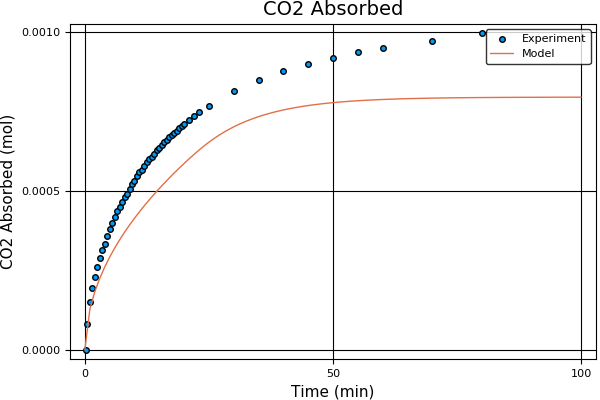

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [7]:
plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1] for i in linspace(0,tf,100)]*A, lab = "Model")

In [8]:
V = 5.5e-6     #Volume of emulsion, m3
A = pi*.03^2   #Area of petri dish, m2
L = V/A        #m
k2 = 8.67       #m3/mol.s      Taken at from Supp Matt of Vericella
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p(t) = 140000   #Pa            #Consider pure CO2 environment.
tf = 6000.0       #s 
ɛ  = 0.75
c0 = 0.0;

#This function is a little subtle. See my workbook, after p. 8
f2 = function (c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    cKion = 600                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end

ftemp = function (c,w)
    wdot = -k2*c*Sl/Ss*w/60
    return wdot
end
w0 = 1e3;     #Initial OH- concentration, mol/m3
m = 100


@time sol2 = LinearSIP(f2,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#@time sol = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#plot(linspace(0,tf,100),[sol2(i)[2m+1] for i in linspace(0,tf,100)])
#plot(sol(30)[m+1:2m])

#Compare with Experiment
tdata = [0, 0.25, 0.5, 1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,21,22,23,25,30,35,40,45,50,55,60,70,80]  #Time in minutes
pdata = [1.55,1.4430,1.4370,1.4317,1.4284,1.4257,1.4235,1.4213,1.4195,1.4179,1.4161,1.4145,1.4130,1.4117,1.4103,1.4092,1.4080,1.4070,1.4061,1.4051,1.4039,1.4031,1.4020,1.4010,1.4005,1.3996,1.3987,1.3980,1.3974,1.3968,1.3959,1.3953,1.3947,1.3940,1.3934,1.3928,1.3923,1.3917,1.3912,1.3906,1.3902,1.3896,1.3887,1.3877,1.3868,1.3853,1.3819,1.3792,1.3771,1.3755,1.3741,1.3727,1.3718,1.3700,1.3682]            #Pressure Data in bar
pleak = [.00018*tdata[i] for i in 1:length(tdata)]
pdata = pdata + pleak
plot(tdata,pdata)
V_container = 330e-6      #Volume of container, m3 
T = 298                   #Temperature, K
R = 8.314                 #J/K.mol
DeltaN = [(pdata[2] - pdata[i])*1e5*V_container/(R*T) for i in 2:length(pdata)]

#plot(tdata[2:end],DeltaN)

#Compare this with Model - remember to adjust for small surface area:
A = pi*.03^2
#plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
#plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1] for i in linspace(0,tf,100)]*A, lab = "Model")

9.238539 seconds (52.09 M allocations: 4.229 GB, 9.09% gc time)



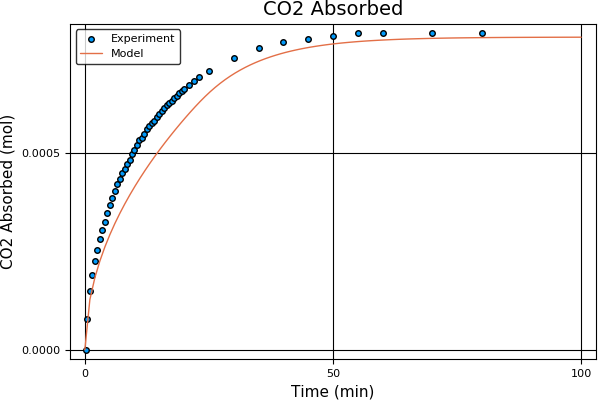

In [9]:
plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1] for i in linspace(0,tf,100)]*A, lab = "Model")

# More Experimental Data - Spherical Run 

In [10]:
R = 0.001       #Radius, m
k2 = 8.67       #m3/mol.s      Taken at from Supp Matt of Vericella
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p(t) = 110000   #Pa            #Consider pure CO2 environment.
tf = 6000.0       #s 
ɛ  = 0.75
c0 = 0.0;

#This function is a little subtle. See my workbook, after p. 8
f2 = function (c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    cKion = 600                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end

ftemp = function (c,w)
    wdot = -k2*c*Sl/Ss*w/60
    return wdot
end
w0 = 1e3;     #Initial OH- concentration, mol/m3
m = 100


@time sol2 = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#@time sol = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#plot(linspace(0,tf,100),[sol2(i)[2m+1] for i in linspace(0,tf,100)])
#plot(sol(30)[m+1:2m])


tdata = [0.5, 1,1.5, 2 ,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,15,20,25,30]
pdata = [1.1047,1.1011,1.0993,1.0985,1.0979,1.0975,1.097,1.0969,1.0968,1.0966,1.0964,1.0963,1.0963,1.0963,1.096,1.096,1.0959,1.0959,1.0957,1.0957,1.0952,1.095,1.0949,1.095]

#Compare with Experiment
plot(tdata,pdata)
V_container = 330e-6      #Volume of container, m3 
T = 298                   #Temperature, K
R_gas = 8.314                 #J/K.mol
DeltaN = [(pdata[2] - pdata[i])*1e5*V_container/(R_gas*T) for i in 2:length(pdata)]

#plot(tdata[2:end],DeltaN)

#Compare this with Model - remember to adjust for small surface area:
A = pi*.03^2
#plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
#plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1] for i in linspace(0,tf,100)]*A, lab = "Model")

7.795334 seconds (40.20 M allocations: 3.233 GB, 9.83% gc time)



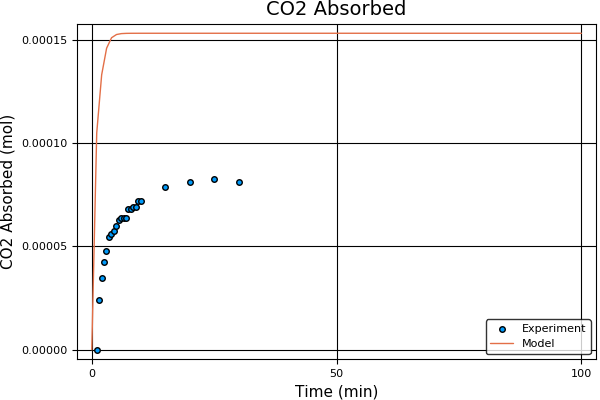

In [11]:
plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1]*(1.18/(1e6*4/3*pi*R^3)) for i in linspace(0,tf,100)], lab = "Model")

# Use 'Verified model' to compare MECS and SIPs Material 

In [12]:
RSIP = 0.00005       #Radius, m
k2 = 8.67       #m3/mol.s      Taken at from Supp Matt of Vericella
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p(t) = 110000   #Pa            #Consider pure CO2 environment.
tf = 45.0       #s 
ɛ  = 0.5
c0 = 0.0;
RLiq = RSIP*(1-ɛ)^(1/3)

#This function is a little subtle. See my workbook, after p. 8
cKion = 600
function fsolidSIPS(c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    #cKion = 600                 #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end
function fsolidMECS(c,w)
   #Data for Function
    Keq = 1/(1.78e-4)*1e-3                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    #cKion = 600                  #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*w             #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end

w0 = 1e3;     #Initial OH- concentration, mol/m3
m = 75


@time solSIPS = SphericalSIP(fsolidSIPS,RSIP,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#println([((Sl+cKion*0.5)*(1-ɛ)+Ss*ɛ)*4/3*pi*RSIP^3, solSIPS(tf)[2m+1]])
@time solMECS = SphericalMECSNoShell(fsolidMECS,RLiq,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#@time sol = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#plot(linspace(0,tf,100),[sol2(i)[2m+1] for i in linspace(0,tf,100)])
#plot(sol(30)[m+1:2m])

3.505461 seconds (7.26 M allocations: 509.265 MB, 3.32% gc time)
  3.408091 seconds (6.11 M allocations: 392.744 MB, 2.86% gc time)


Assympototes
[1.02382e-10,1.03162e-10,8.60422e-11,8.68336e-11]



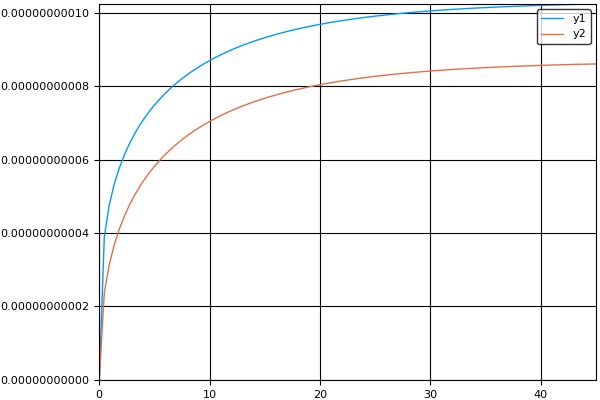

In [13]:
plot(linspace(0,tf,100),[solSIPS(i)[2m+1] for i in linspace(0,tf,100)])
println("Assympototes")
println([solSIPS(tf)[2m+1] , (4/3*pi*RSIP^3)*((Sl*p(0.0)+cKion*0.5)*(1-ɛ)+Ss*ɛ*p(0.0)), solMECS(tf)[2m+1], (4/3*pi*RLiq^3)*(Sl*p(0.0)+cKion*0.5) ])
plot!(linspace(0,tf,100),[solMECS(i)[2m+1] for i in linspace(0,tf,100)])

In [14]:
#Bigger Particle
tf = 350
RSIP = 0.00025
RLiq = RSIP*(1-ɛ)^(1/3)
@time solSIPS = SphericalSIP(fsolidSIPS,RSIP,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#println([((Sl+cKion*0.5)*(1-ɛ)+Ss*ɛ)*4/3*pi*RSIP^3, solSIPS(tf)[2m+1]])
@time solMECS = SphericalMECSNoShell(fsolidMECS,RLiq,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#@time sol = SphericalSIP(f2,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#plot(linspace(0,tf,100),[sol2(i)[2m+1] for i in linspace(0,tf,100)])
#plot(sol(30)[m+1:2m])

  2.335655 seconds (13.92 M allocations: 1.185 GB, 11.41% gc time)
  0.582064 seconds (3.64 M allocations: 312.974 MB, 11.86% gc time)


Assympototes
[1.28939e-8,1.28953e-8,1.08584e-8,1.08542e-8]



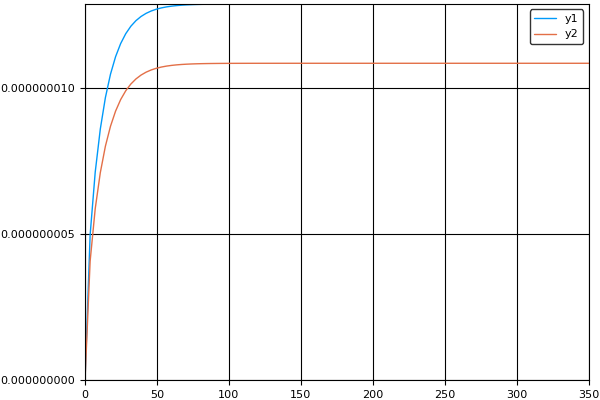

In [15]:
plot(linspace(0,tf,100),[solSIPS(i)[2m+1] for i in linspace(0,tf,100)])
println("Assympototes")
println([solSIPS(tf)[2m+1] , (4/3*pi*RSIP^3)*((Sl*p(0.0)+cKion*0.5)*(1-ɛ)+Ss*ɛ*p(0.0)), solMECS(tf)[2m+1], (4/3*pi*RLiq^3)*(Sl*p(0.0)+cKion*0.5) ])
plot!(linspace(0,tf,100),[solMECS(i)[2m+1] for i in linspace(0,tf,100)])

In [16]:
4/3*π*RSIP^3*((300+Sl*p(0))*(1-ɛ) + Ss*p(0)*ɛ)

1.2895256095281854e-8

In [17]:
4/3*π*RSIP^3*(1e3+Sl*p(0)*(1-ɛ) + Ss*p(0)*ɛ) / solSIPS(tf)[2m+1] 

5.3147274018980415

In [18]:
solMECS(tf)[2m+1]

1.0858361424533844e-8

In [19]:
solMECS(tf)[2m+1]

1.0858361424533844e-8

In [20]:
function SphericalMECSTake2(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m,Dactive)
    
    #Pertinent Mesh Values
    h = R/(m+1/2)         #Distance between neighbouring grid points
    r(j) = h*(j-1/2)      #Radial distance of point j
    
    #Generic Ddash and kdash parameters
    #Ddash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Sl/Ss)
    #kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Sl/Ss)
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[1] = Dl/(r(1)^2*h^2)*r(1+1/2)^2*(c[2] - c[1]) - k2*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Dl/(r(i)^2*h^2)*(r(i+1/2)^2*c[i+1]  - (r(i+1/2)^2+r(i-1/2)^2)*c[i] + r(i-1/2)^2*c[i-1]) - k2*c[i]*w[i]
            elseif i == m
                dudt[m] = Dl/(r(m)^2*h^2)*(r(m+1/2)^2*Sl*p(t) - (r(m+1/2)^2+r(m-1/2)^2)*c[m] + r(m-1/2)^2*c[m-1]) - k2*c[m]*w[m]
            elseif i == m+1
                dudt[i] = Dactive/(r(1)^2*h^2)*r(1+1/2)^2*(w[2] - w[1]) + f(c[i-m],w[i-m])
            elseif m+2 <= i <= 2m-1
                dudt[i] = Dactive/(r(i)^2*h^2)*(r(i+1/2)^2*w[i+1-m]  - (r(i+1/2)^2+r(i-1/2)^2)*w[i-m] + r(i-1/2)^2*w[i-1-m]) + f(c[i-m],w[i-m])
            elseif i == 2m
                dudt[i] = Dactive/(r(m)^2*h^2)*(r(m+1/2)^2*w[m-1] - (r(m+1/2)^2+r(m-1/2)^2)*w[m] + r(m-1/2)^2*w[m-1]) + f(c[i-m],w[i-m])
            elseif i == 2m+1
                dudt[i] = 4π*R^2*((3/2*Sl*p(t)-2*c[m]+1/2*c[m-1])/h)*Dl
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end

SphericalMECSTake2 (generic function with 1 method)

In [21]:
function SphericalMECSTake3(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m,Dactive)
    
    #Pertinent Mesh Values
    h = R/(m+1/2)         #Distance between neighbouring grid points
    r(j) = h*(j-1/2)      #Radial distance of point j
    
    #Generic Ddash and kdash parameters
    #Ddash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Sl/Ss)
    #kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Sl/Ss)
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[1] = Dl/(r(1)^2*h^2)*r(1+1/2)^2*(c[2] - c[1]) - k2*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Dl/(r(i)^2*h^2)*(r(i+1/2)^2*c[i+1]  - (r(i+1/2)^2+r(i-1/2)^2)*c[i] + r(i-1/2)^2*c[i-1]) - k2*c[i]*w[i]
            elseif i == m
                dudt[m] = Dl/(r(m)^2*h^2)*(r(m+1/2)^2*Sl*p(t) - (r(m+1/2)^2+r(m-1/2)^2)*c[m] + r(m-1/2)^2*c[m-1]) - k2*c[m]*w[m]
            elseif i == m+1
                dudt[i] = f(c[i-m],w[i-m])
            elseif m+2 <= i <= 2m-1
                dudt[i] = f(c[i-m],w[i-m])
            elseif i == 2m
                dudt[i] =  f(c[i-m],w[i-m])
            elseif i == 2m+1
                dudt[i] = 4π*R^2*((3/2*Sl*p(t)-2*c[m]+1/2*c[m-1])/h)*Dl
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end

SphericalMECSTake3 (generic function with 1 method)

In [22]:
DeltaN

23-element Array{Float64,1}:
 0.0       
 2.39751e-5
 3.46307e-5
 4.26224e-5
 4.79502e-5
 5.46099e-5
 5.59419e-5
 5.72738e-5
 5.99377e-5
 6.26016e-5
 6.39336e-5
 6.39336e-5
 6.39336e-5
 6.79294e-5
 6.79294e-5
 6.92614e-5
 6.92614e-5
 7.19253e-5
 7.19253e-5
 7.8585e-5 
 8.12489e-5
 8.25808e-5
 8.12489e-5

In [23]:
DeltaN_new

LoadError: UndefVarError: DeltaN_new not defined


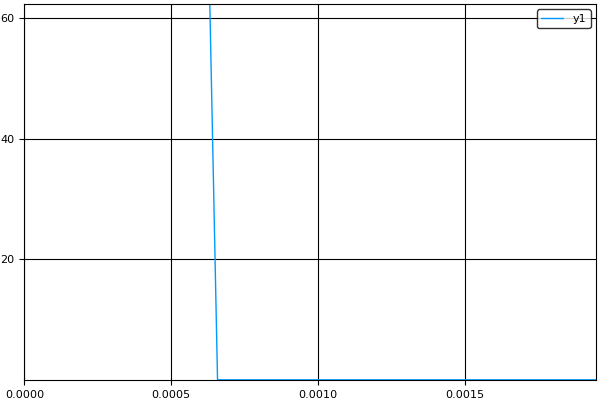

In [24]:
plot(linspace(0,L,m),sol2(1000)[m+1:2m])

In [25]:
L

0.0019452270822342764


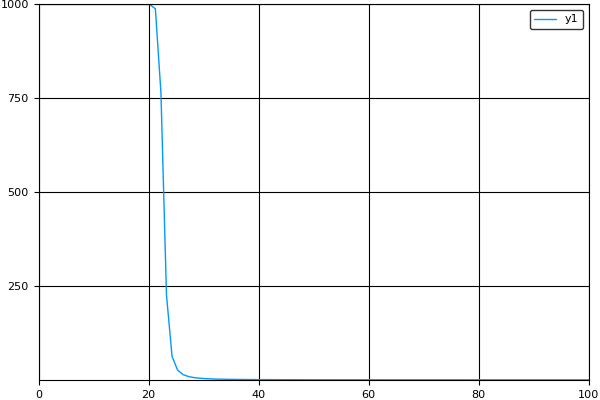

In [26]:
plot(linspace(0,100,100),[sol2(i)[2m+1] for i in linspace(0,100,100)])

In [27]:
5.5/28

0.19642857142857142


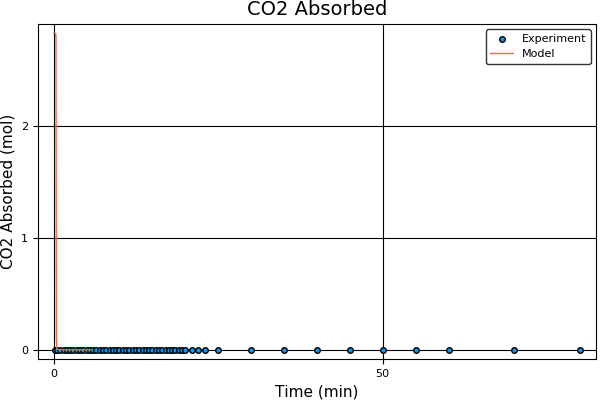

In [28]:
tdata = [0, 0.25, 0.5, 1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,21,22,23,25,30,35,40,45,50,55,60,70,80]  #Time in minutes
pdata = [1.55,1.4430,1.4370,1.4317,1.4284,1.4257,1.4235,1.4213,1.4195,1.4179,1.4161,1.4145,1.4130,1.4117,1.4103,1.4092,1.4080,1.4070,1.4061,1.4051,1.4039,1.4031,1.4020,1.4010,1.4005,1.3996,1.3987,1.3980,1.3974,1.3968,1.3959,1.3953,1.3947,1.3940,1.3934,1.3928,1.3923,1.3917,1.3912,1.3906,1.3902,1.3896,1.3887,1.3877,1.3868,1.3853,1.3819,1.3792,1.3771,1.3755,1.3741,1.3727,1.3718,1.3700,1.3682]            #Pressure Data in bar
pleak = [.00018*tdata[i] for i in 1:length(tdata)]
pdata = pdata + pleak
plot(tdata,pdata)
V_container = 330e-6      #Volume of container, m3 
T = 298                   #Temperature, K
R = 8.314                 #J/K.mol
DeltaN = [(pdata[2] - pdata[i])*1e5*V_container/(R*T) for i in 2:length(pdata)]

#plot(tdata[2:end],DeltaN)

#Compare this with Model - remember to adjust for small surface area:
A = pi*.03^2
plot(tdata[2:end],DeltaN, line=:scatter, title="CO2 Absorbed", ylabel="CO2 Absorbed (mol)", xlabel="Time (min)",lab="Experiment")
plot!(linspace(0,tf,100)/60,[sol2(i)[2m+1] for i in linspace(0,tf,100)]*A, lab = "Model")

In [29]:
pleak = [.00018*tdata[i] for i in 1:length(tdata)]

55-element Array{Float64,1}:
 0.0    
 4.5e-5 
 9.0e-5 
 0.00018
 0.00027
 0.00036
 0.00045
 0.00054
 0.00063
 0.00072
 0.00081
 0.0009 
 0.00099
 ⋮      
 0.00396
 0.00414
 0.0045 
 0.0054 
 0.0063 
 0.0072 
 0.0081 
 0.009  
 0.0099 
 0.0108 
 0.0126 
 0.0144 

In [30]:
#Analytic Test - Linear Case

L = 0.3;
k2 = 10.0
Ss = 1.0
Sl = 1.0
Ds = 1.0
Dl = 10.0
p(t) = 1.0
tf = 30.0
ɛ=0.0
c0 = 0.0;
w0 = 1.0;
m = 50
f(c,w) = 0.0
@time sol = LinearSIP(f,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
#@time sol = SphericalSIP(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);

#Assymptotic Analytical Solution
x = linspace(0,L,m+1)[1:m]
solassymptote = cosh(x*sqrt(k2/Dl))/cosh(L*sqrt(k2/Dl))

plot(sol(2.0)[1:m])
plot!(sol(3.0)[1:m])
plot!(x,solassymptote)

#Analytic Test - Spherical Case

R = 0.3; 
k2 = 10.0
Ss = 1.0
Sl = 1.0
Ds = 1.0
Dl = 0.1
p(t) = 1.0
tf = 30.0
ɛ=0.0
c0 = 0.0;
w0 = 1.0;
m = 50
f(c,w) = 0.0
#@time sol = LinearSIP(f,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);
@time sol = SphericalSIP(f,R,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m);

#Assymptotic Analytical Solution
r = linspace(0.5*(R/(m+0.5)),R,m+1)[1:m]
solassymptoteradial = sinh(r*sqrt(k2/Dl))./(r/R*sinh(R*sqrt(k2/Dl)))

plot(sol(3.5)[1:m])
plot!(sol(.1)[1:m])
plot!(solassymptoteradial)

  0.241717 seconds (801.78 k allocations: 51.704 MB, 8.78% gc time)


0.139646 seconds (717.88 k allocations: 46.311 MB, 8.52% gc time)



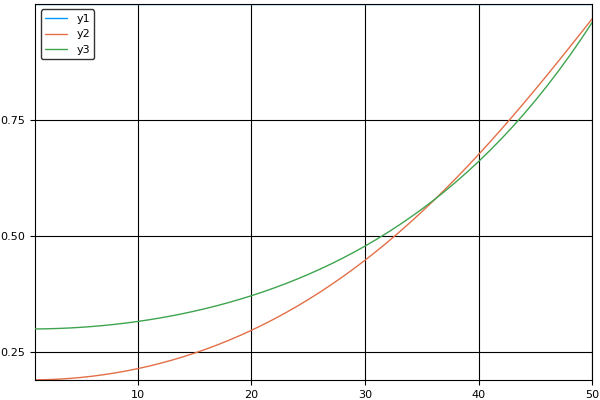

In [31]:
plot(sol(3.5)[1:m])
plot!(sol(.1)[1:m])
plot!(solassymptoteradial)

## Junk

In [32]:
#Calculate Mesh Parameters
L = 1.0
kdash = 10.0
Ss = 1.0
p(t) = 1.0
f(c,w) = -.01*kdash*c*w
tf = 10000.0
Ddash = 0.01

m = 50          #Number of mesh points
h = L/m         #Distance between neighbouring grid points

#Define Matrix A
DDash = 1.0
A = Ddash/h^2*(-2*diagm(ones(m))+diagm([2;ones(m-2)],1)+diagm(ones(m-1),-1))

#Define DE Problem
maintemp = function (t,u,dudt)
    #Extract values
    c = u[1:m]
    w = u[m+1:2m]
    #Diffusion term
    cdotDiff = A*c 
    #Reaction Terms
    for i = 1:m-1
        dudt[i] = cdotDiff[i] - kdash*c[i]*w[i]
    end
    dudt[m] = cdotDiff[m] - kdash*c[m]*w[m] + Ddash/h^2*Ss*p(t)
    for i = m+1:2m
        dudt[i] = f(c[i-m],w[i-m])
    end
end

c0 = zeros(m)
w0 = ones(m)
u0 = [c0;w0]
tspan = (0.0,tf)
prob = ODEProblem(maintemp,u0,tspan)
sol = solve(prob, Rosenbrock23());


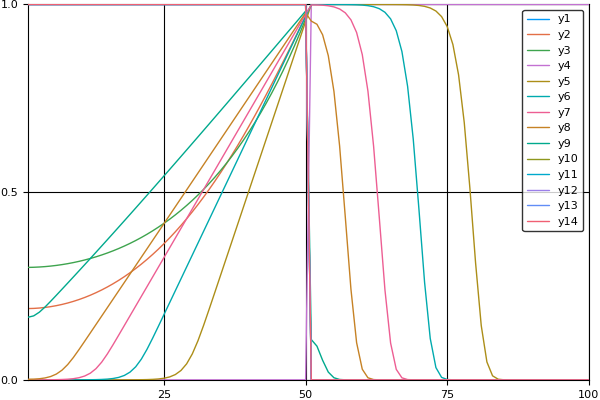

In [33]:
plot!(sol(0.0)[1:2m])
for i = 1:9
    plot!(sol(1000*i)[1:2m])
end
plot!(sol(10000)[1:2m])

In [34]:
Ddash/h^2*(-2*diagm(ones(m))+diagm([2;ones(m-1)],1)+diagm(ones(m-1),-1))

LoadError: DimensionMismatch("dimensions must match")

In [35]:
[2;ones(m-1)]

50-element Array{Float64,1}:
 2.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [36]:
#Packages we are using
using DifferentialEquations
using Plots

#Function to model the absorption of gas into SIP material in linear coordinates via MOL approach.
#Discussed on p. 8 of workbook.
#Inputs: f - function for rate of change in reactive species concentration. 
#L - length of domain, m
#tf - end time of simulation, s. 
#p - partial pressure of gas above SIP (this must be a function of time.), Pa.
#c0 and w0 - initial CO2 and reactant concentration
#k2 - second order rate constant, m3/mol.s
#Ss and Sl - solubility of gas in solid and liquid phases, respectively, mol/m3.Pa
#Ds and Dl - diffusivity of gas in solid and liquid phases, respectively, m2/s
#ɛ - The solid fraction inside the particle.

function LinearSIPOLD(f,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ)
    
    #Pertinent Mesh Values
    m = 50          #Number of mesh points
    h = L/m         #Distance between neighbouring grid points
    
    #Generic Ddash and kdash parameters
    DDash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Ss/Sl)
    kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Ss/Sl)
    
    #Define Matrix A
    A = Ddash/h^2*(-2*diagm(ones(m))+diagm([2;ones(m-2)],1)+diagm(ones(m-1),-1))

    #Define DE Problem
    maintemp = function (t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion
        cdotDiff = A*c 
        
        #Add in reaction terms
        for i = 1:m-1
            dudt[i] = cdotDiff[i] - kdash*c[i]*w[i]
        end
        dudt[m] = cdotDiff[m] - kdash*c[m]*w[m] + Ddash/h^2*Ss*p(t)
        for i = m+1:2m
            dudt[i] = f(c[i-m],w[i-m])
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m)]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(maintemp,u0,tspan)
    sol = solve(prob, ImplicitEuler(),dt=1/2^4);
    return sol
end

LinearSIPOLD (generic function with 1 method)

In [37]:
#Example with reasonably realistic values.

L = 6e-2        #m
k2 = 20.0       #m3/mol.s      Taken at infinite dilution from confirmation report.
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p(t) = 101300     #Pa            Consider 10% CO2 environment.
tf = 9000.0      #s 
ɛ_p = 0.5       #              Voidage of SIPS material.

#This function is a little subtle. See my workbook, after p. 8
ftemp = function (c,w)
   #Data for Function
    Keq = 5.0                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    cKion = 6000                 #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w       #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end
w_initial = 1e-1;     #Initial OH- concentration, mol/m3
m = 50

@time (sol, qbar_0) = MonolithMTZintime(ftemp,δ,tf,w_initial,k2,Ss,Sl,Ds,Dl,ɛ_p,m,p_0)
@time sol                   = LinearSIP(ftemp,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m)
#Convert to length-scale
w = 5*δ         #m             Width of monolith cell
v = 1         #m/s           Superficial Gas Velocity
T = 300         #K             Temperature of flue gas
R = 8.314       #J/mol.K       Universal gas constant
ɛ = (w-2δ)/(w+2δ)             #Bulk Voidage inside bed
β = ɛ*v/(ɛ+(1-ɛ)*qbar_0/(p_0/(R*T)))    #Velocity of MTZ
MTZinspace(z) = sol(z/β)[2m+1]/(δ*qbar_0)      #Function for q/qbar_0 in space (constant pattern)

LoadError: UndefVarError: MonolithMTZintime not defined